In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import utilities


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# ticker = "AAPL"
# df = utilities.load_stock(ticker)
ticker = 'SPY'
df = utilities.load_index(ticker)

In [5]:
# Add Indicators

df = utilities.RSI(df, 14)
df = utilities.RSI(df, 28)
df = utilities.RSI(df, 56)
df = utilities.RSI(df, 100)
df = utilities.RSI(df, 200)

df = utilities.MACD(df)

df = utilities.EMA(df, 10)
df = utilities.EMA(df, 50)
df = utilities.EMA(df, 200)

df = utilities.market_hours_only(df)
df = utilities.time_to_numeric(df)

In [6]:
df.head()

,timestamp,open,high,low,close,volume,ticker,date,time,minute,...,rsi28,rsi56,rsi100,rsi200,macd,signal,histogram,ema10,ema50,ema200
49,2005-01-03 09:30:00,1.1568,1.1605,1.1568,1.1602,19181680,AAPL,2005-01-03,09:30:00,570,...,41.6327,NaN,NaN,NaN,-0.0011,-0.0011,-0.0000,1.1591,1.1611,NaN
50,2005-01-03 09:31:00,1.1604,1.1627,1.1598,1.1604,4815272,AAPL,2005-01-03,09:31:00,571,...,42.1053,NaN,NaN,NaN,-0.0009,-0.0011,0.0001,1.1593,1.1611,NaN
51,2005-01-03 09:32:00,1.1600,1.1611,1.1573,1.1575,3166912,AAPL,2005-01-03,09:32:00,572,...,40.0000,NaN,NaN,NaN,-0.0010,-0.0010,0.0000,1.1590,1.1609,NaN
52,2005-01-03 09:33:00,1.1575,1.1620,1.1566,1.1573,3206000,AAPL,2005-01-03,09:33:00,573,...,38.0392,NaN,NaN,NaN,-0.0011,-0.0010,-0.0000,1.1587,1.1607,NaN
53,2005-01-03 09:34:00,1.1573,1.1621,1.1530,1.1536,6159384,AAPL,2005-01-03,09:34:00,574,...,33.2192,NaN,NaN,NaN,-0.0014,-0.0011,-0.0003,1.1577,1.1604,NaN


In [7]:
# map the "minute" column, from 570 to 930, to 0 to 1

df['minute'] = df['minute'].apply(lambda x: (x - 570) / (960 - 570))

In [8]:
# Drop non-numeric columns
df = df.drop(columns=['timestamp', 'ticker', 'date', 'time'])

In [9]:
df.head()

,open,high,low,close,volume,minute,rsi14,rsi28,rsi56,rsi100,rsi200,macd,signal,histogram,ema10,ema50,ema200
49,1.1568,1.1605,1.1568,1.1602,19181680,0.000000,42.7673,41.6327,NaN,NaN,NaN,-0.0011,-0.0011,-0.0000,1.1591,1.1611,NaN
50,1.1604,1.1627,1.1598,1.1604,4815272,0.002564,47.6190,42.1053,NaN,NaN,NaN,-0.0009,-0.0011,0.0001,1.1593,1.1611,NaN
51,1.1600,1.1611,1.1573,1.1575,3166912,0.005128,40.6977,40.0000,NaN,NaN,NaN,-0.0010,-0.0010,0.0000,1.1590,1.1609,NaN
52,1.1575,1.1620,1.1566,1.1573,3206000,0.007692,40.2299,38.0392,NaN,NaN,NaN,-0.0011,-0.0010,-0.0000,1.1587,1.1607,NaN
53,1.1573,1.1621,1.1530,1.1536,6159384,0.010256,33.1754,33.2192,NaN,NaN,NaN,-0.0014,-0.0011,-0.0003,1.1577,1.1604,NaN


In [10]:
# normalize all other columns
for col in df.columns:
    if col != 'enter':
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

In [11]:
# Create a column called "value", which repserents how many of the next closes after this one are higher than the current close.
# The window is 390*5, to mean the next 5 days, so the last 100 values will be NaN.


window = 390 * 5 - 1 # Adjusted the window size

# Create a column called "value"
df['value'] = df['close'].rolling(window=window).apply(lambda x: np.mean(x > x.iloc[-1])) 
df['value'] = df['value'].shift(-window)

In [12]:
df.head()

,open,high,low,close,volume,minute,rsi14,rsi28,rsi56,rsi100,rsi200,macd,signal,histogram,ema10,ema50,ema200,value
49,0.000193,0.000206,0.000196,0.000211,0.084400,0.000000,0.427673,0.413208,NaN,NaN,NaN,0.538711,0.516205,0.531692,0.000194,0.000181,NaN,0.014879
50,0.000212,0.000217,0.000211,0.000212,0.021187,0.002564,0.476190,0.418275,NaN,NaN,NaN,0.538778,0.516205,0.531799,0.000195,0.000181,NaN,0.015906
51,0.000210,0.000209,0.000199,0.000197,0.013935,0.005128,0.406977,0.395704,NaN,NaN,NaN,0.538744,0.516244,0.531692,0.000193,0.000180,NaN,0.014879
52,0.000197,0.000214,0.000195,0.000196,0.014107,0.007692,0.402299,0.374683,NaN,NaN,NaN,0.538711,0.516244,0.531692,0.000192,0.000179,NaN,0.012314
53,0.000196,0.000214,0.000177,0.000177,0.027102,0.010256,0.331754,0.323009,NaN,NaN,NaN,0.538611,0.516205,0.531370,0.000187,0.000178,NaN,0.014366


In [13]:
df.describe()

,open,high,low,close,volume,minute,rsi14,rsi28,rsi56,rsi100,rsi200,macd,signal,histogram,ema10,ema50,ema200,value
count,1.872110e+06,1.872110e+06,1.872110e+06,1.872110e+06,1.872110e+06,1.872110e+06,1.872110e+06,1.872110e+06,1.872103e+06,1.872059e+06,1.871959e+06,1.872110e+06,1.872110e+06,1.872110e+06,1.872110e+06,1.872110e+06,1.871960e+06,1.870161e+06
mean,2.247339e-01,2.247923e-01,2.247843e-01,2.247339e-01,4.231840e-03,4.993335e-01,5.033288e-01,5.063214e-01,5.127070e-01,5.533731e-01,4.353562e-01,5.392592e-01,5.168435e-01,5.316823e-01,2.249835e-01,2.252486e-01,2.256718e-01,4.438676e-01
std,2.732701e-01,2.733460e-01,2.733317e-01,2.732706e-01,7.220205e-03,2.893179e-01,1.590071e-01,1.204791e-01,1.007793e-01,9.062494e-02,6.473106e-02,1.903831e-02,2.066531e-02,1.846944e-02,2.735866e-01,2.739309e-01,2.744498e-01,3.540300e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.877937e-02,2.878621e-02,2.878562e-02,2.877937e-02,6.971269e-04,2.487179e-01,3.902440e-01,4.220204e-01,4.433946e-01,4.915349e-01,3.910768e-01,5.368737e-01,5.142327e-01,5.294433e-01,2.879740e-02,2.881708e-02,2.886803e-02,9.030272e-02
50%,1.139722e-01,1.139942e-01,1.139944e-01,1.139722e-01,1.754337e-03,5.000000e-01,5.000000e-01,5.039356e-01,5.107150e-01,5.514088e-01,4.334681e-01,5.391116e-01,5.166692e-01,5.316916e-01,1.140939e-01,1.142237e-01,1.144567e-01,3.930221e-01
75%,2.538114e-01,2.538428e-01,2.538935e-01,2.538151e-01,5.012330e-03,7.487179e-01,6.155928e-01,5.896598e-01,5.807265e-01,6.137339e-01,4.786652e-01,5.414830e-01,5.192605e-01,5.339400e-01,2.541118e-01,2.544919e-01,2.548398e-01,7.916880e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.994869e-01


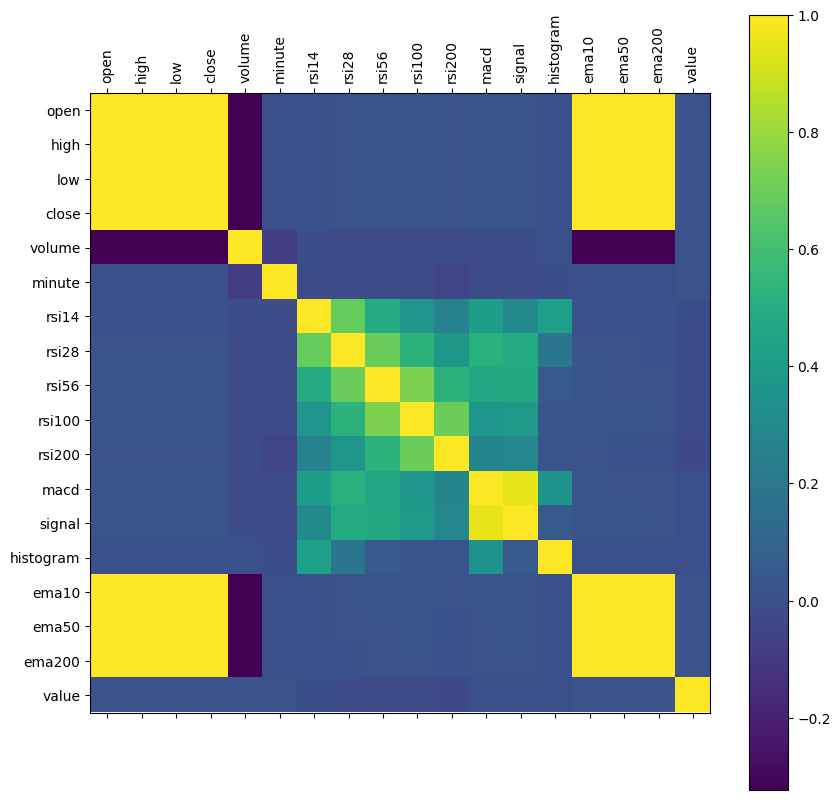

In [14]:
# show the correlation matrix
correlation_matrix = df.corr()
plt.matshow(correlation_matrix)

plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar()
plt.gcf().set_size_inches(10, 10)

plt.show()

In [16]:
filename = 'valued_{}.csv'.format(ticker)
df.to_csv(filename, index=False)